In [26]:
import torch, re
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [27]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 2

test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""

test_sentence = re.sub(r'[^A-Za-z \n]', '', test_sentence)
test_sentence = re.sub(r'\n', ' ', test_sentence).lower().split()

In [28]:
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]

ngrams[:3]

[(['forty', 'when'], 'winters'),
 (['winters', 'forty'], 'shall'),
 (['shall', 'winters'], 'besiege')]

In [29]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [30]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [31]:
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [42]:
for epoch in range(200):
    total_loss = 0
    for contex, target in ngrams:
        contex_idxs = torch.tensor([word_to_ix[w] for w in contex], dtype=torch.long)

        model.zero_grad()
        preds = model(contex_idxs)
        loss = loss_function(preds, torch.tensor([word_to_ix[target]], dtype=torch.long))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)
    print(f'{epoch}) Total Loss: {total_loss}', end='\r')

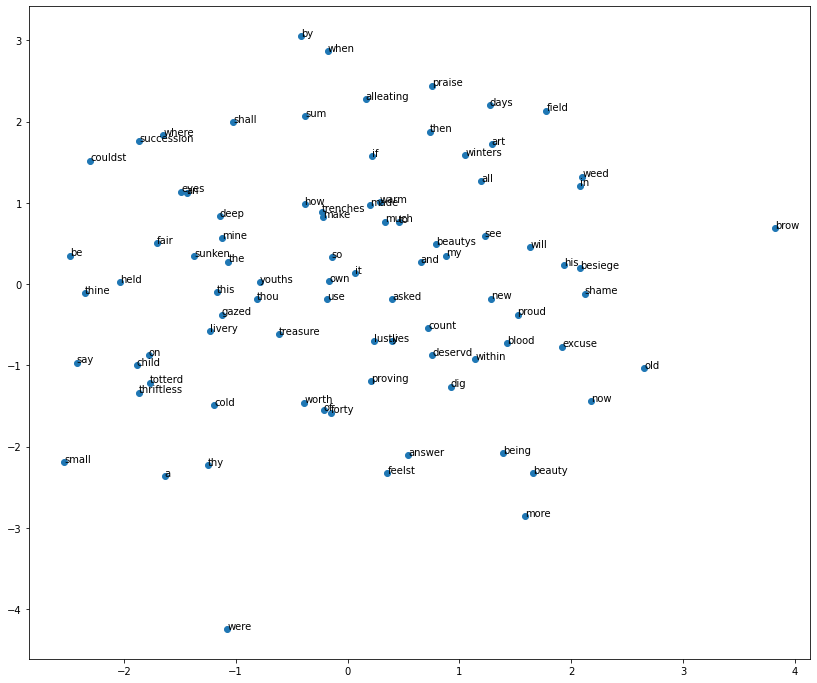

In [43]:
fig, ax = plt.subplots()
w2v = model.embeddings.weight.detach().numpy()

fig.set_figheight(12)
fig.set_figwidth(14)
ax.scatter(w2v[:, 0], w2v[:, 1])

for word, num in word_to_ix.items():
    ax.annotate(word, w2v[num])

plt.show()